CS235 Project - Fall 2024
- Alex Cupps (acupp002)
- Zach Schwartz (zschw004)

In [251]:
#Cell reserved for all needed imports
import numpy as np
import pandas as pd
import math
import random 
from collections import Counter
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import umap.umap_ as umap



Before we begin to analyze our data, we must first load it from the .data file provided, along with assigning the column names for the respective features:

In [3]:
columns = ['ID',
           'Diagnosis',
           'radius1',
           'texture1',
           'perimeter1',
           'area1',
           'smoothness1',
           'compactness1',
           'concavity1',
           'concave_points1',
           'symmetry1',
           'fractal_dimension1',
           'radius2',
           'texture2',
           'perimeter2',
           'area2',
           'smoothness2',
           'compactness2',
           'concavity2',
           'concave_points2',
           'symmetry2',
           'fractal_dimension2',
           'radius3',
           'texture3',
           'perimeter3',
           'area3',
           'smoothness3',
           'compactness3',
           'concavity3',
           'concave_points3',
           'symmetry3',
           'fractal_dimension3'
           ]

data = pd.read_csv('data/wdbc.data', header=None, sep=',', names=columns)
print(data.head())


         ID Diagnosis  radius1  texture1  perimeter1   area1  smoothness1  \
0    842302         M    17.99     10.38      122.80  1001.0      0.11840   
1    842517         M    20.57     17.77      132.90  1326.0      0.08474   
2  84300903         M    19.69     21.25      130.00  1203.0      0.10960   
3  84348301         M    11.42     20.38       77.58   386.1      0.14250   
4  84358402         M    20.29     14.34      135.10  1297.0      0.10030   

   compactness1  concavity1  concave_points1  ...  radius3  texture3  \
0       0.27760      0.3001          0.14710  ...    25.38     17.33   
1       0.07864      0.0869          0.07017  ...    24.99     23.41   
2       0.15990      0.1974          0.12790  ...    23.57     25.53   
3       0.28390      0.2414          0.10520  ...    14.91     26.50   
4       0.13280      0.1980          0.10430  ...    22.54     16.67   

   perimeter3   area3  smoothness3  compactness3  concavity3  concave_points3  \
0      184.60  2019.0  

<h2>1. Implementing simple classifiers [15pts]</h2>
- What to implement: In this question you should implement (1) a decision tree classifier
that uses the Information Gain splitting criterion and (2) a Naive Bayes classifier which uses
Gaussian modeling for continuous features.
- What to plot: You should produce a bar-chart that shows the performance of your classifiers
on the dataset.


We will be creating a decision tree classifier using the information gain splitting criterion to effectively utilize the feature at each node that provides us with the most information gain about our target feature, 'Diagnosis' - telling us whether or not a breast mass is malignant (M) or benign (B). 
<br><br>
First, we must prepare the data for the decision tree. First, we will drop the ID column and data from our dataset, as this data is not relevant to our predictive model. Next, we will create two new variables:
1. features - the data for all features in our dataset other than the target
2. target - the target feature of our dataset (Diagnosis) - determining whether a tumor is benign or malignant. We will convert the diagnosis data from categorical to numerical for the decision tree classifier.

In [397]:

if 'ID' in data.columns:
    data = data.drop(columns=['ID'])
    
features = data.drop(columns=['Diagnosis']).values
target = data['Diagnosis'].map({'M': 1, 'B': 0}).values

features_df = pd.DataFrame(features, columns=columns[2:])
print(features_df.head())


   radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
0    17.99     10.38      122.80  1001.0      0.11840       0.27760   
1    20.57     17.77      132.90  1326.0      0.08474       0.07864   
2    19.69     21.25      130.00  1203.0      0.10960       0.15990   
3    11.42     20.38       77.58   386.1      0.14250       0.28390   
4    20.29     14.34      135.10  1297.0      0.10030       0.13280   

   concavity1  concave_points1  symmetry1  fractal_dimension1  ...  radius3  \
0      0.3001          0.14710     0.2419             0.07871  ...    25.38   
1      0.0869          0.07017     0.1812             0.05667  ...    24.99   
2      0.1974          0.12790     0.2069             0.05999  ...    23.57   
3      0.2414          0.10520     0.2597             0.09744  ...    14.91   
4      0.1980          0.10430     0.1809             0.05883  ...    22.54   

   texture3  perimeter3   area3  smoothness3  compactness3  concavity3  \
0     17.33      184.60 

Next, we will create a function 'calculate_entropy' that takes the various values in the dataset and calculate the entropy, or level of purity.

In [79]:
def calculate_entropy(x):
    counts = np.bincount(x)
    probabilities = counts / len(x)
    entropy = 0

    for prob in probabilities:
        if prob > 0:
            entropy += prob * abs(np.log2(prob))

    return entropy

Now that we have our entropy calculation completed, we need to create a function for calculating information gain. Since our features are mainly continuous, we should not perform exact value splits - doing so would lead to many small (and mostly single-item) bins, which would result in overfitting of our model. Instead, we will come up with thresholds between values for our splitting.

In [80]:
def calculate_information_gain(dataset, labels, feature):
    
    #sort the indexes of the dataset for the given feature
    sorted = np.argsort(dataset[:, feature])

    #apply the sorting to the feature data and labels
    sorted_data = dataset[sorted]
    sorted_labels = labels[sorted]

    #start at the top, calculating entropy level of the dataset
    #to determine the level of purity
    parent_entropy = calculate_entropy(labels)

    #iterate over possible thresholds and get the indexes on each side
    top_info_gain = 0
    top_threshold = None
    for i in range(1, len(sorted_data)):

        threshold = (sorted_data[i-1, feature] + sorted_data[i, feature]) / 2
        #left split is a boolean array containing True for the indexes with a value less than the threshold
        #right split is a boolean array containing True for the indexes with a value greater than or equal to the threshold
        left_split = sorted_data[:, feature] < threshold
        right_split = sorted_data[:, feature] >= threshold

        #next we calculate the entropies for the left and right sides of the split
        #this will tell us how effective the split is, and we will maximize information gain
        left_split_entropy = calculate_entropy(sorted_labels[left_split])
        right_split_entropy = calculate_entropy(sorted_labels[right_split])

        #calculate the weights of the left and right splits for use in the overall weight entropy calculation
        weight_l = np.sum(left_split) / len(sorted_data)
        weight_r = np.sum(right_split) / len(sorted_data)

        #calculate the overall weighted entropy of the current split
        weighted_split_entropy = weight_l * left_split_entropy + weight_r * right_split_entropy

        #using the weighted split entropy, calculate the information gain of the threshold
        #if the information gain is higher than any we've come across thus far, set as the top one
        information_gain = parent_entropy - weighted_split_entropy
        if information_gain > top_info_gain:
            top_info_gain = information_gain
            top_threshold = threshold

    return top_info_gain, top_threshold

Now that we've created our functions to calculate entropy and weighted information gain, we will create the Decision Tree Classifier itself. First, we need to create a Node class to store various attributes (feature index, threshold, left of threshold values, right of threshold values) of the node we are evaluating:

In [81]:
class TreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):

        #feature: index of feature being used for split
        self.feature = feature

        #threshold: threshold for the split
        self.threshold = threshold

        #left: the left node, contains all values < threshold
        self.left = left

        #right: the right node, contains all values >= threshold
        self.right = right

        #value: value (0 or 1 for benign or malignant) assigned when a leaf node is reached
        #remains None until leaf node is found, then returns the value
        self.value = value

    def leaf_node_reached(self):
        if self.value is not None:
            return True
        else:
            return False

Next, we will create our DecisionTreeClassifier class. This object contains all relevant methods for building our decision tree, recursively building tree nodes and calculating/maximizing information gain. I've annotated each method below with comments on its purpose: 

In [82]:
class DecisionTreeClassifier:
    def __init__(self, maximum_tree_depth):

        #maximum_tree_depth (int): the maximum depth for our tree
        self.maximum_tree_depth = maximum_tree_depth

        self.tree = None

    def fit(self, dataset, labels):
        #method containing all logic to train our classifier
        self.tree = self.build_tree(dataset, labels)

    def build_tree(self, dataset, labels, cur_tree_depth=0):
        #this method is where the bulk of the work is handled for building our decision tree

        #label count gives us the number of labels in the current sample set
        #label count of 1 indicates perfect purity (one of our stopping criteria)
        label_ct = len(np.unique(labels))

        #we first check our stoppage criteria, to see if we've reached a leaf node
        #if our current depth has hit the stoppage depth defined, OR
        #if the label count has a value of 1
        if cur_tree_depth >= self.maximum_tree_depth or label_ct == 1:
            #return leaf node with the most common class label
            leaf_value = self.get_top_label(labels)
            return TreeNode(value=leaf_value)

        #call get_top_split() to calculate the top feature and threshold
        top_feature, top_threshold = self.get_top_split(dataset, labels)
        if top_feature is None:
            #no feature being returned indicates we've reached a leaf node
            #return this TreeNode object with the leaf value found
            leaf_value = self.get_top_label(labels)
            return TreeNode(value=leaf_value)

        #split data on top feature and threshold
        #then build the sub trees off using this split
        left_split = dataset[:, top_feature] < top_threshold
        right_split = dataset[:, top_feature] >= top_threshold
        left_sub_tree = self.build_tree(dataset[left_split], labels[left_split], cur_tree_depth + 1)
        right_sub_tree = self.build_tree(dataset[right_split], labels[right_split], cur_tree_depth + 1)

        return TreeNode(feature=top_feature, threshold=top_threshold, left=left_sub_tree, right=right_sub_tree)

    def get_top_split(self, dataset, labels):

        feature_ct = dataset.shape[1]
        top_feature = None
        top_threshold = None
        top_info_gain = 0

        #iterate over the features and determine which feature/threshold provide the highest information gain
        for feature in range(feature_ct):
            info_gain, threshold = calculate_information_gain(dataset, labels, feature)
            if info_gain > top_info_gain:
                top_info_gain = info_gain
                top_feature = feature
                top_threshold = threshold

        return top_feature, top_threshold

    def get_top_label(self, labels):
        #returns the most common label in the array
        #we call this function to determine whether benign or malignant samples are more prominent
        return np.bincount(labels).argmax()

    def predict(self, dataset):
        predictions = []
        for point in dataset:
            #append the predicted label value to our predictions list
            predictions.append(self.predict_datapoint(point, self.tree))
        return np.array(predictions)

    def predict_datapoint(self, point, node):
        #first check if we've reached a leaf node
        #if so, return the determined label value
        if node.leaf_node_reached():
            return node.value
        
        #if not leaf value, continue down the left or right tree nodes
        if point[node.feature] < node.threshold:
            return self.predict_datapoint(point, node.left)
        else:
            return self.predict_datapoint(point, node.right)

    #required getter and setter functions for our object 
    def get_params(self, deep=True):
        return {"maximum_tree_depth": self.maximum_tree_depth}

    def set_params(self, maximum_tree_depth=None):
        self.maximum_tree_depth = maximum_tree_depth
        return self

The two main classes for our given dataset is Benign and Malignant.  The two classes will help separate the training data based on our target variable of 'Diagnosis'.  There are four methods defined for these two classes:

- benign_data()/malignant_data(): The training data is spliced on whether an associated column contains 0 for benign or 1 for malignant.  This label encoding was established earlier to easily reference the two classes
- mean(): calculates the mean of each feature
- variance(): calculates variance of each feature
- gaussianProbability(): assuming a normal Gaussian distribution, the probability of each feature in a data sample/instance.  The mean/variance calculated above is utilized within this method.  Feature probabilities are combined using logarithmic summation which is more stable at handling miniscule values.  Values of zero found in mean/variance were redefined as 1E-12 to avoid possibility of dividing by zero.  Similar logic is applied to the probability of a feature value being found in a class



In [83]:
#Separating the data by class 
class Benign:
    #Having benign data be instance method allows method to call on itself
    def benign_data(self, features, target):
        x_train_b = features[target == 0]
        return x_train_b
    
    def mean(self, x_train_b):
        mean_value = {}
        mean_value = np.mean(x_train_b, axis = 0)
        return mean_value
    def variance(self, x_train_b):
        variance = {}
        variance = np.var(x_train_b, axis = 0)
        return variance
    #Probability calculation requires parameters of class data set, index being called plus pre-calculated mean & variance
    
    def gaussianProbability(self, x_train_b, index, mean,variance):     
        #Defining the probability sum before loop so function can add up all probabilities through each run in loop
        sum_logP = 0
        #Loop will go through all the data points within the columns
        for feature_array in range(x_train_b.shape[1]):
         #After parsing through a feature, x captures the data sample/instance within index that is called
            x = x_train_b[index, feature_array]
            μ = mean[feature_array]
            σ = variance[feature_array]
            #Handling zero values to avoid breaking Gaussian Probability calculation
            if σ == 0:
                σ = 1E-12
            if μ ==0:
                μ = 1E-12
                #Setting up Naive Bayes proability calculation on continuous features by splitting numerator and denominator
                #Assumes dataset has a Gaussian Distribution
            num = math.exp(-(x-μ)**2/(2*σ))
            denom = math.sqrt(2 * math.pi * σ)
            P = num/denom
                #Ensuring probability will not get too close to 0
            if P <= 0:
                P = 1E-18
                #Using summation o
                #Using summation of log function over product of posterior probability since log handles small numbers better
            logP= (math.log(P))
                #Variable increases the count of logP
            sum_logP += logP
        return sum_logP


class Malignant:
    def malignant_data(self, features, target):
        x_train_m = features[target == 1]
        return x_train_m
    
    def mean(self, x_train_m):
        mean_value = {}
        #Calculating mean of the numerical features in dataset
        mean_value = np.mean(x_train_m, axis = 0)
        return mean_value
    def variance(self, x_train_m):
        variance = {}
        #Calculating variance of numerical features in databset
            #Recording the variance value for each individual feature
        variance = np.var(x_train_m, axis = 0)
        return variance
    #Probability calculation requires parameters of class data set, index being called plus pre-calculated mean & variance
    def gaussianProbability(self, x_train_m, index, mean,variance):     
        #Defining the probability sum before loop so function can add up all probabilities through each run in loop
        sum_logP = 0
         #Loop will go through all the data points within the columns
        for feature_array in range(x_train_m.shape[1]):
         #After parsing through a feature, x captures the data sample/instance within index that is called
            x = x_train_m[index, feature_array]
            μ = mean[feature_array]
            σ = variance[feature_array]
            #Handling zero values to avoid breaking Gaussian Probability calculation
            if σ == 0:
                σ = 1E-12
            if μ ==0:
                μ = 1E-12
                #Setting up Naive Bayes proability calculation on continuous features by splitting numerator and denominator
                #Assumes dataset has a Gaussian Distribution
            num = math.exp(-(x-μ)**2/(2*σ))
            denom = math.sqrt(2 * math.pi * σ)
            P = num/denom
                #Ensuring probability will not get too close to 0
            if P <= 0:
                P = 1E-18
                #Using summation o
                #Using summation of log function over product of posterior probability since log handles small numbers better
            logP= (math.log(P))
                #Variable increases the count of logP
            sum_logP += logP
        return sum_logP
    


A split of the features into training and testing data is employed shortly before fitting the Naive Bayes model.  Using same exact dataset to fit and test performance of model presents a risk of overfitting to this particular dataset.  Dividing the features allows a more holisitic evaluation of the model

In [84]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)


Next, we create a NaiveBayesClassifier object to help us classify our data samples as benign or malignant. Below is a breakdown of the class:

- init(): initialize the object
- fit(): the method for training our NB classifier. In this method, we calculate the prior probabilities for both malignant and benign label values. We then train the classifier based off of these prior beliefs, and calculate the mean and variance values for both the malignant and benign labels.
- predict(): in this method, we compute the actual prediction value of the label for a given row of data in our test split dataset. We calculate the Gaussian probability for each class label (B vs. M). Whichever one is higher is the predictive value we assign to the data.
- get_params() / set_params(): allows for getting and setting of the object's values dynamically. These two methods are required in order to work with SKLearn's cross_val_score function that we utilize in order to calculate the performance of our model (without these two methods, errors are thrown when trying to call the function).


In [85]:
class NaiveBayesClassifier:
    def __init__(self, priors=None):
        self.benign = Benign()
        self.malignant = Malignant()
        self.priors = priors if priors is not None else {}

    def fit(self, x_train, y_train):
        n_total = len(y_train)
        n_benign = np.sum(y_train== 0)
        n_malignant = np.sum(y_train == 1)
        self.priors['benign'] = n_benign / n_total
        self.priors['malignant'] = n_malignant / n_total
        self.x_train_b = self.benign.benign_data(x_train, y_train)
        self.mean_b = self.benign.mean(self.x_train_b)
        self.variance_b = self.benign.variance(self.x_train_b)

        self.x_train_m = self.malignant.malignant_data(x_train, y_train)
        self.mean_m = self.malignant.mean(self.x_train_m)
        self.variance_m = self.malignant.variance(self.x_train_m)

    def predict(self, x_test):
            
        predictions = []

        for index in range(len(x_test)):
            #Compute probabilities, and assign the predicted class of 0 (benign) or 1 (malignant)
            #depending on which probability is higher
            gauss_test_B = self.benign.gaussianProbability(x_test, index, self.mean_b, self.variance_b)
            gauss_test_M = self.malignant.gaussianProbability(x_test, index, self.mean_m, self.variance_m)
            pred_class = 0 if gauss_test_B > gauss_test_M else 1
            predictions.append(pred_class)

        return np.array(predictions)

    def get_params(self, deep=True):
        return {'priors': self.priors}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


Now that we've created our decision tree and naive bayes classifiers, we will begin the process of testing the performance and analyzing our results. Below, we've created two functions:

1. test_performance() - this function has two arguments, X (the data matrix) and y (the label values). 
2. get_f1() - a helper function called by our test_performance function. This function takes four arguments - the data matrix and label values passed in from test_performance, along with the stratified k fold and classifier objects we've created. We return sklearn's cross_val_score call on our parameters, which returns an array containing the f1 scores at each fold in the cross validation.

In [86]:
def test_performance(classifier, X, y,num_splits):
    kfold = StratifiedKFold(n_splits=num_splits, shuffle=True)
    f1_scores = get_f1(X, y, kfold, classifier)

    mean_f1_scores = np.mean(f1_scores)
    stdev_f1_scores = np.std(f1_scores)

    return mean_f1_scores, stdev_f1_scores

def get_f1(X, y, skf, classifier):
    return cross_val_score(classifier, X, y, cv=skf, scoring=make_scorer(f1_score, average='weighted'))

Once we've built our performance calculating functions, we want to plot our results. We call test_performance, and get the mean and standard deviation values of our f1 scores at each fold, for both of our classifiers. With these two values, we build up a plot to show each classifier's performance, along with the levels of error:

Decision Tree F1 Mean: 0.9364422581202767
Decision Tree F1 Std. Dev.: 0.0495255404127498
Naive Bayes F1 Mean: 0.949848101674727
Naive Bayes F1 Std. Dev.: 0.04581999610277177


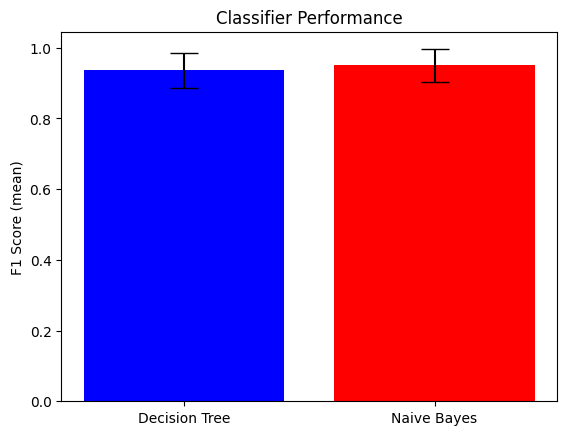

In [87]:
def plot_performance(classifier_names, mean_f1, std_f1):
    fig, ax = plt.subplots()
    ax.bar(classifier_names, mean_f1, yerr=std_f1, color=['blue', 'red'], capsize=10)
    ax.set_ylabel('F1 Score (mean)')
    ax.set_title('Classifier Performance')
    plt.show()

#initialize the decision tree classifier obj and NB classifier obj
dec_tree = DecisionTreeClassifier(maximum_tree_depth=5)
nb = NaiveBayesClassifier()

#train the classifiers on the reduced training data
dec_tree.fit(x_train, y_train)
nb.fit(x_train, y_train)

dec_tree_mean_f1, dec_tree_std_f1 = test_performance(
    dec_tree, 
    x_test, 
    y_test, 
    10)

nb_mean_f1, nb_std_f1 = test_performance(
    nb, 
    x_test, 
    y_test,
    10)

print(f"Decision Tree F1 Mean: {dec_tree_mean_f1}")
print(f"Decision Tree F1 Std. Dev.: {dec_tree_std_f1}")
print(f"Naive Bayes F1 Mean: {nb_mean_f1}")
print(f"Naive Bayes F1 Std. Dev.: {nb_std_f1}")

classifier_names = ["Decision Tree", "Naive Bayes"]
f1_means = [dec_tree_mean_f1, nb_mean_f1]
f1_stds = [dec_tree_std_f1, nb_std_f1]

plot_performance(classifier_names, f1_means, f1_stds)

Based on these results, we can see that both the decision tree classifier and the Naive Bayes classifier are performing well, with around a 0.94 and 0.95 mean F1 score respectively, which indicates our classifiers are effectively handling our imbalanced dataset and considering false positives and false negatives. The standard deviation for the decision tree model (roughly 0.06) tells us that the classifier is doing a reasonable (but not great) job of preventing overfitting of the data.  The Naive Bayes is performing better than the decision tree classifier, with a mean F1 score of 0.95 and a more respectable standard deviation of 0.03.

<h2>2. Dimensionality reduction with the Singular Value Decomposition [10pts]</h2>
What to implement: The Singular Value Decomposition (SVD) is an extremely useful tool
from linear algebra that can help us approximate a data matrix (such as the instance-by-feature matrix that represents our data) into a smaller dimension, hence reduce the dimensionality of the data. In this question you should use the SVD (you may use the existing NumPy library) to approximate the data in different ranks. Important: because we are dealing with supervised learning, given a train/test split, in order to avoid data leakage you should always make sure that you only compute the SVD on the train split and project the test instances to that space, in the same way that the Latent Semantic Analysis paper [1] does.
<br><br>
What to plot: You should produce a figure that shows the performance of your classifiers as
a function of the SVD approximation rank

In [88]:
#first, we split our data using train/test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

#then, utilize numpy's singluar value decomposition function on only our training split
#this decomposes our training data matrix into three separate matrices
U, S, Vh = np.linalg.svd(X_train)

#create reduce() function with the following parameters:
#U: the orthonormal columns of our data
#S: the diagonal matrix of our data
#Vh: the orthonormal rows of our data
#rank: the rank we use to approximate the data 
def reduce(U, S, Vh, rank):
    #reduce each of our three matrices based on the rank passed in
    reduced_U = U[:, :rank]
    reduced_S = np.diag(S[:rank])
    reduced_Vh = Vh[:rank, :]

    #multiply the reduced versions of U and S to get the reduced version of our original training data matrix
    reduced_train_data = np.dot(reduced_U, reduced_S)
    
    return reduced_train_data

Once we've written our code for reducing the based on the top number of singular values and vectors (our 'rank'), we now want to create a helper function to project the test data split based on reduced space we created with the SVD functionality:

In [89]:
def project_test(test_data, transpose_matrix):
    return np.dot(test_data, transpose_matrix)

Next, we want to create another helper function to evlauate our decision tree and naive bayes classifiers on the projected test data in the reduced space:

In [90]:
def evaluate(X_train_reduced, X_test_reduced, y_train, y_test):
    
    #initialize the decision tree classifier obj and NB classifier obj
    dec_tree = DecisionTreeClassifier(maximum_tree_depth=5)
    nb = NaiveBayesClassifier()

    #train the classifiers on the reduced training data
    dec_tree.fit(X_train_reduced, y_train)
    nb.fit(X_train_reduced, y_train)

    #calculate the performance of each classifier using the helper function
    #test_performance() that we created earlier along in the project
    dec_tree_mean_f1, dec_tree_stdev_f1 = test_performance(dec_tree, X_test_reduced, y_test, 10)
    nb_mean_f1, nb_stdev_f1 = test_performance(nb, X_test_reduced, y_test, 10)

    print(f"dec_tree_mean_f1: {dec_tree_mean_f1}")
    print(f"dec_tree_stdev_f1: {dec_tree_stdev_f1}")
    print(f"nb_mean_f1: {nb_mean_f1}")
    print(f"nb_stdev_f1: {nb_stdev_f1}")

    #only returning the mean values since these are what we're plotting on our SVD approx. graph
    return dec_tree_mean_f1, nb_mean_f1

Once we've created our evaluate function, we can begin evaluating the performance of each of our classifiers across different ranks (or number of utilized features). For sake of performance, we've gone ahead and created a ranks list containing intervals of 5 up to 30, the total number of features we have originally. <br><br>
We iterate over each rank, evaluate our classifiers performance at each once, then create a plot displaying the respective mean F1 scores for each classifier.

---------------
Rank -10-
X_train_reduced shape -(426, 10)-
X_test_reduced shape -(143, 10)-
dec_tree_mean_f1: 0.9365040401634829
dec_tree_stdev_f1: 0.04952851384880917
nb_mean_f1: 0.9364475084598924
nb_stdev_f1: 0.03839038729092286
---------------
Rank -20-
X_train_reduced shape -(426, 20)-
X_test_reduced shape -(143, 20)-
dec_tree_mean_f1: 0.9153057537577661
dec_tree_stdev_f1: 0.06968868307532886
nb_mean_f1: 0.9438771823291947
nb_stdev_f1: 0.042561416121387856
---------------
Rank -30-
X_train_reduced shape -(426, 30)-
X_test_reduced shape -(143, 30)-
dec_tree_mean_f1: 0.9227492025518341
dec_tree_stdev_f1: 0.048499956389856456
nb_mean_f1: 0.9305777813517752
nb_stdev_f1: 0.06864210149105489


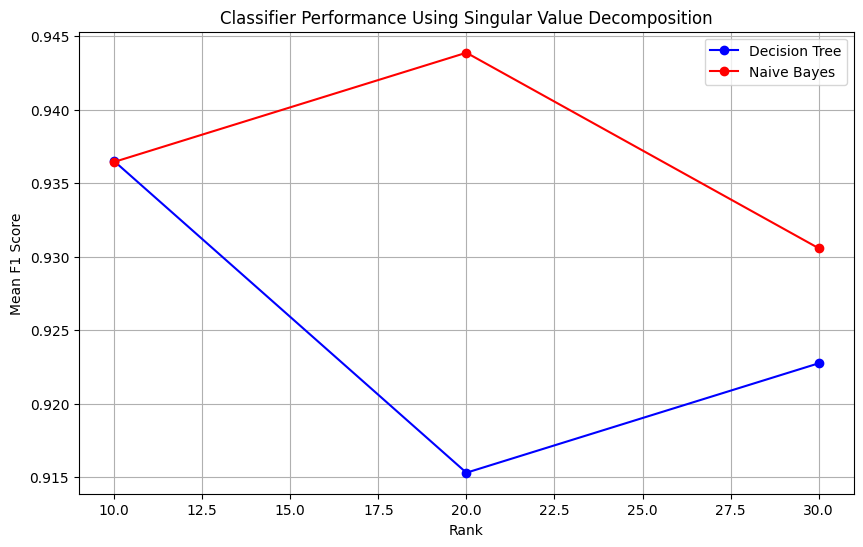

In [91]:
rank_list = [10, 20, 30]
dec_tree_f1_per_rank = []
nb_f1_per_rank = []

for rank in rank_list:
    #reduce the training data using SVD
    X_train_reduced = reduce(U, S, Vh, rank)
    
    #reduce the test data to match the training data
    Vh_reduced = Vh[:rank, :]
    X_test_reduced = project_test(X_test, np.transpose(Vh_reduced))

    print("---------------")
    print(f"Rank -{rank}-")
    print(f"X_train_reduced shape -{X_train_reduced.shape}-") 
    print(f"X_test_reduced shape -{X_test_reduced.shape}-")

    scaler = StandardScaler()
    X_train_reduced = scaler.fit_transform(X_train_reduced)
    X_test_reduced = scaler.transform(X_test_reduced)
    
    #evaluate our classifier performances on the reduced train and test data
    dec_tree_f1, nb_f1 = evaluate(X_train_reduced, X_test_reduced, y_train, y_test)
    dec_tree_f1_per_rank.append(dec_tree_f1)
    nb_f1_per_rank.append(nb_f1)

plt.figure(figsize=(10, 6))
plt.plot(rank_list, dec_tree_f1_per_rank, label='Decision Tree', marker='o', color='blue')
plt.plot(rank_list, nb_f1_per_rank, label='Naive Bayes', marker='o', color='red')
plt.xlabel('Rank')
plt.ylabel('Mean F1 Score')
plt.title('Classifier Performance Using Singular Value Decomposition')
plt.legend()
plt.grid(True)
plt.show()


Given the graph above, we can see our mean F1 scores for the decision tree and Naive Bayes classifiers differ depending on the number of features utilized when training. We believe the steady decline in mean F1 score for the NB classifier could potentially be attributed to its assumption of independence between each feature, therefore struggling as more features are added. On the flip side, the DT classifier is able to maintain a higher mean F1 with more features, as it does a better job capturing and understanding complex feature interactions and dependencies.

<h2>3. Feature selection with randomization [15pts]</h2>

What to implement: Randomization is a very powerful tool in helping us understand whether a piece of data contains useful information for a given task or whether the information contained is close to random. In this question you should implement the following feature selection technique which randomizes each feature of the data and measures how predictive it is for our task. In order to avoid data leakage, for this question only you should conduct the feature selection on a 20% stratified random sample of the entire dataset, leaving the rest 80as the data on which you will report the performance on your plot.
<br>
• For every feature, generate a copy of the dataset where that feature values are randomized (i.e., randomly permuted)
<br>
• Train two versions of the model, one with the actual data and one with the data that contains the randomized feature.
<br>
• Test on part of the hold out that is for validation and use the difference in performance as a score for that feature.
<br>
• Steps b and c should be done as part of 5-fold cross-validation train/test splits on the feature selection sample and produce an average F1 score for each of the two models (regular and “randomized feature”)
<br>
• If randomization of the feature results in a drop of performance, the percentage of the drop can be used to characterize how important this feature is for the task
<br>
• Repeat for all features and rank features according to the above metric, from most pre- dictive to least predictive 
<br>
What to plot (2 figures in total): A bar chart that shows each feature and the calculated importance.

The permutatingColumn method takes a copy of original dataset and randomly permutates a column with the excpetion of target column 'Diagnosis'.  The column that was randomly permutated gets returned.  

In [92]:
#Creating a copy of original dataset for random permutation

#Method that loops through all columns and randomly permutates each feature
def permutatingColumn(data,column_index, target_col_index):
    random_perm_data = data.copy()
    if column_index != target_col_index:
        random_perm_data[:, column_index] = np.random.permutation(random_perm_data[:, column_index])
    return random_perm_data


Splitting the datset to set up for model training.  As detailed in the instructions, one of the model trainings will follow our standard dataset while the second one incorporates 20% stratified random sampling and the remaining 80% for testing will consist purely of the original dataset.  In order to keep data consistent with the classifiers written from scratch, encoding of the target feature Diagnosis was applied on the randomly permutated dataset.  
- 20% of dataset is used to randomly shuffle all features
- 80% dataset is untouched and used for testing at the end

In [93]:
#Feature selection on the 20% stratified random sample of entire dataset

feature_selection_data, model_training_data = train_test_split(data, test_size=0.8, random_state=42, stratify=data['Diagnosis'])
x_selection = feature_selection_data.drop(columns=['Diagnosis']).values
y_selection = feature_selection_data['Diagnosis'].map({'M': 1, 'B': 0}).values
x_holdout = model_training_data.drop(columns=['Diagnosis']).values
y_holdout = model_training_data['Diagnosis'].map({'M': 1, 'B': 0}).values


Below is where we start training the model with the created method dual_model_performance.  Both Decision Tree & Naive Bayes classifier are evaluated on a five fold cross validation.  The dataset copy containing a randomly permutated column gets evaluated in the two classifiers alongside the original dataset for a baseline comparison.  A comparison dictionary is created at the end of this function containing the following keys:

- decisionTree_original: F1 mean of original dataset
- decisitonTree_random: F1 mean of randomly permutated feature dataset
- naiveBayes_original: F1 mean of orignal dataset
- naiveBayes_random: F1 mean of randomly permutated feature dataset
- decisionTree_difference: absolute value difference between F1 means of original and randomly permutated feature dataset
- naiveBayes_difference: absolute value difference between F1 means of original and randomly permutated feature dataset
- decisionTree_percentDrop: percent change exhibiting in Decision Tree classifier when one feature gets randomly permutated
- naiveBayes_percentDrop: percent change exhibiting in Naive Bayes classifier when one feature gets randomly permutated

In [94]:
#Creating method that evaluates and compares both models against OG & randomized datasets
def dual_model_performance(model1, model2, x_train, y_train, x_test, y_test, x_train_R, y_train_R, x_test_R, y_test_R):
    #Evaluating Decision Tree model on original dataset
    model1.fit(x_train, y_train)
    dec_tree_mean_f1, dec_tree_std_f1 = test_performance(
        DecisionTreeClassifier(maximum_tree_depth=5), x_test, y_test, 5)
    
    #Re-evaluate Decision Tree model on randomly permutated dataset
    model1.fit(x_train_R, y_train_R)
    dec_tree_r_mean_f1, dec_tree_r_std_f1 = test_performance(
        DecisionTreeClassifier(maximum_tree_depth=5), x_test_R, y_test_R, 5)

    #Evaluating Naive Bayes on original dataset
    model2 = NaiveBayesClassifier()
    model2.fit(x_train, y_train)
    nb_mean_f1, nb_std_f1 = test_performance(
        NaiveBayesClassifier(), x_test, y_test, 5)
    
    #Re-evaluate Naive Bayes model on randomly permutated dataset
    model2 = NaiveBayesClassifier()
    model2.fit(x_train_R, y_train_R)
    nb_r_mean_f1, nb_r_std_f1 = test_performance(
        NaiveBayesClassifier(), x_test_R, y_test_R, 5)

#Generating a comparision dictionary to store results
    comparisonModels = { 
        'decisionTree_original': dec_tree_mean_f1, 
        'decisionTree_random': dec_tree_r_mean_f1,
        'naiveBayes_original': nb_mean_f1,
        'naiveBayes_random': nb_r_mean_f1,
        'decisionTree_difference': abs(dec_tree_mean_f1 - dec_tree_r_mean_f1),
        'naiveBayes_difference': abs(nb_mean_f1 - nb_r_mean_f1),
        'decisionTree_percentDrop' : (abs(dec_tree_mean_f1 - dec_tree_r_mean_f1)/dec_tree_mean_f1) * 100,
        'naiveBayes_percentDrop' : (abs(nb_mean_f1 - nb_r_mean_f1)/nb_mean_f1) * 100
    }

    return comparisonModels


After establishing a method to evaluate performance of both datasets on the Decision Tree & Naive Bayes classifier, features pass through a loop where they individually will get randomly permutated to see how important they are to this dataset.



rp_data variable represents the training data containing a randomly permutating column.  It utilizes one of the initial methods permutating columns to randomly permutate a column in the copied dataset.  The loop is set up to ensure all features will be the feature randomly permutated in the dataset copy.


The feature_importanceScore dictionary stores feature_index being tested and the percentDrop calculated for both classifiers.

In [ ]:
target_col_index = 0
feature_importanceScore = []

dt = DecisionTreeClassifier(maximum_tree_depth=5)
nb = NaiveBayesClassifier()

#Looping through the features indexes of all columns in training data
for feature_index in range(x_selection.shape[1]):
    rp_data = permutatingColumn(x_selection, feature_index, target_col_index)
    comparison = dual_model_performance(
        model1=dt,
        model2=nb,
        x_train=x_selection, y_train=y_selection,
        x_test=x_selection, y_test=y_selection,
        x_train_R=rp_data, y_train_R=y_selection,
        x_test_R=x_selection, y_test_R=y_selection
    )
    feature_importanceScore.append({
        'feature_index': feature_index, 
        'percentDrop_DT': comparison.get('decisionTree_percentDrop'),
        'percentDrop_NB': comparison['naiveBayes_percentDrop']
    })


The features are sorted within method sortedFeatureImportance based on which randomly permutated features resulted in the biggest change in performance after being tested by the two classifiers.  

The sortedFeatures variable sorts the percent drop in performance of the two classifiers in descending order (reverse = True). Lambda function key helps iterate over all percent drops to arrange in descending order.
Each feature index is matched with the feature name based on column names assigned at the very beginning section of this code.  An offset of 2 is added since ID column got dropped due to not being a value add and 'Diagnosis' is the target feature not utilized in training data set.

After rankedFeatures is returned at end of method, two variables for Decision Tree & Naive Bayes Classiers are set up calling the top 10 indexes within the sortedFeatureImportance method to rank the top 10 features for each classifier

In [ ]:
def sortedFeatureImportance(feature_importanceScore, columns, classifier):
    sorted_features = sorted(feature_importanceScore, key=lambda x: x[f'percentDrop_{classifier}'], reverse=True)
    rankedFeatures = []
    for feature in sorted_features:
        feature_index = feature['feature_index']
        #Adding 2 to skip Diagnosis & ID Columns
        feature_name = columns[feature_index + 2]
        percentDrop = feature[f'percentDrop_{classifier}']
        rankedFeatures.append((feature_name, percentDrop))
        print(f"Feature: {feature_name} - {classifier} % Drop: {feature[f'percentDrop_{classifier}']}")
    return rankedFeatures

featureRank_DT = sortedFeatureImportance(feature_importanceScore, columns, 'DT')
featureRank_NB = sortedFeatureImportance(feature_importanceScore, columns, 'NB')

topFeatures_DT = [feature[0] for feature in featureRank_DT[:10]]
topFeatures_NB = [feature[0] for feature in featureRank_NB[:10]]


Feature: symmetry2 - DT % Drop: 5.356059616309286
Feature: compactness1 - DT % Drop: 5.256599150107818
Feature: symmetry3 - DT % Drop: 4.928802774234312
Feature: area3 - DT % Drop: 4.701373592751244
Feature: fractal_dimension3 - DT % Drop: 4.3089478586460235
Feature: concave_points1 - DT % Drop: 4.221804626670761
Feature: texture2 - DT % Drop: 4.096042359057327
Feature: compactness2 - DT % Drop: 4.082066159364985
Feature: concave_points2 - DT % Drop: 3.995879000874448
Feature: radius2 - DT % Drop: 3.246575499921907
Feature: area1 - DT % Drop: 3.101413595252586
Feature: radius3 - DT % Drop: 3.015021831672472
Feature: concavity2 - DT % Drop: 2.973039988251597
Feature: smoothness3 - DT % Drop: 2.9607046574973648
Feature: radius1 - DT % Drop: 2.4344151406322987
Feature: symmetry1 - DT % Drop: 2.1455760266043122
Feature: smoothness2 - DT % Drop: 1.989615757659616
Feature: area2 - DT % Drop: 1.9840390459517263
Feature: concave_points3 - DT % Drop: 1.793801917095931
Feature: perimeter3 - DT %

After calculating the features with the highest % drop in performance when removed, we determined the top 10 most important features for our Decision Tree and Naive Bayes classifiers are as follows:

In [ ]:
print(f"Decision Tree - Top 10 Important Features: {topFeatures_DT}")
print(f"Naive Bayes - Top 10 Important Features: {topFeatures_NB}")

Decision Tree - Top 10 Important Features: ['symmetry2', 'compactness1', 'symmetry3', 'area3', 'fractal_dimension3', 'concave_points1', 'texture2', 'compactness2', 'concave_points2', 'radius2']
Naive Bayes - Top 10 Important Features: ['texture1', 'concavity1', 'perimeter3', 'texture2', 'concave_points2', 'area3', 'perimeter1', 'perimeter2', 'smoothness2', 'concavity2']


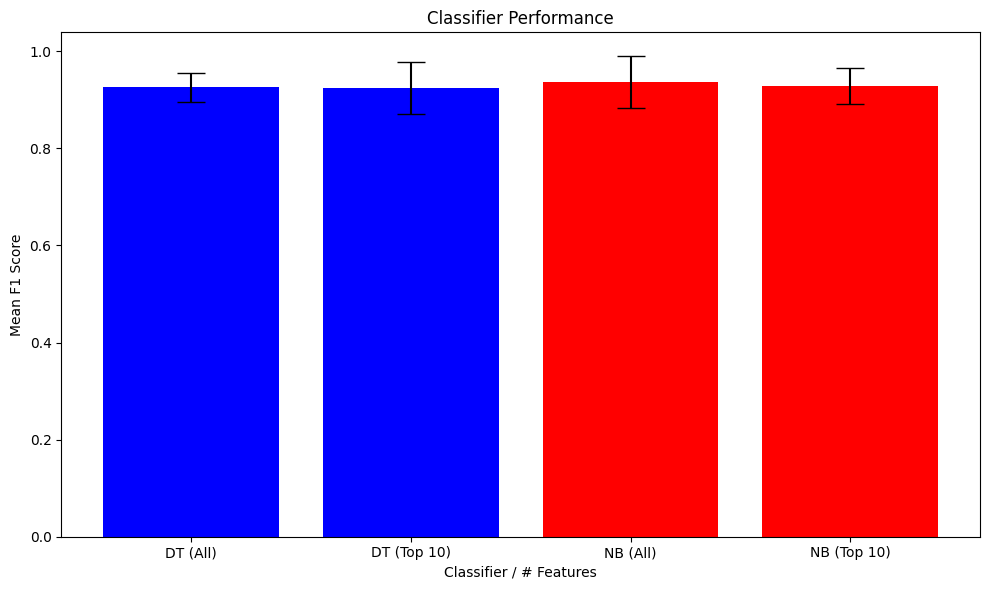

DT (All) Mean F1: 0.9253983553285028
DT (All) Std Dev: 0.030244666226841146
DT (Top 10) Mean F1: 0.9248488323949369
DT (Top 10) Std Dev: 0.05331651952995264
NB (All) Mean F1: 0.9359079283803965
NB (All) Std Dev: 0.05363113687527674
NB (Top 10) Mean F1: 0.9285559418130458
NB (Top 10) Std Dev: 0.03787656417734732


In [ ]:
#Get the data from just top 10 most important features in our 80% split
X_top10_DT = model_training_data[topFeatures_DT].values
X_top10_NB = model_training_data[topFeatures_NB].values

dec_tree_classifier = DecisionTreeClassifier(maximum_tree_depth=5)
nb_classifier = NaiveBayesClassifier()

#Call test_performance to get model performances for all features and top 10 features
dt_all_mean, dt_all_std = test_performance(dec_tree_classifier, x_holdout, y_holdout, 10)
dt_top10_mean, dt_top10_std = test_performance(dec_tree_classifier, X_top10_DT, y_holdout, 10)
nb_all_mean, nb_all_std = test_performance(nb_classifier, x_holdout, y_holdout, 10)
nb_top10_mean, nb_top10_std = test_performance(nb_classifier, X_top10_NB, y_holdout, 10)

classifier_names = [
    "DT (All)", 
    "DT (Top 10)", 
    "NB (All)", 
    "NB (Top 10)"
]
mean_f1_scores = [dt_all_mean, dt_top10_mean, nb_all_mean, nb_top10_mean]
std_f1_scores = [dt_all_std, dt_top10_std, nb_all_std, nb_top10_std]

plt.figure(figsize=(10, 6))
plt.bar(classifier_names, mean_f1_scores, yerr=std_f1_scores, capsize=10, color=['blue', 'blue', 'red', 'red'])
plt.ylabel('Mean F1 Score')
plt.xlabel('Classifier / # Features')
plt.title('Classifier Performance')
plt.tight_layout()
plt.show()

print(f"DT (All) Mean F1: {dt_all_mean}")
print(f"DT (All) Std Dev: {dt_all_std}")
print(f"DT (Top 10) Mean F1: {dt_top10_mean}")
print(f"DT (Top 10) Std Dev: {dt_top10_std}")
print(f"NB (All) Mean F1: {nb_all_mean}")
print(f"NB (All) Std Dev: {nb_all_std}")
print(f"NB (Top 10) Mean F1: {nb_top10_mean}")
print(f"NB (Top 10) Std Dev: {nb_top10_std}")

After looking at our models' performances when using all features and the top 10 most important features for each model, we can see that the Decision Tree classifier performs slightly better when utilizing only the top 10 features, and also decreases its error margin significantly from .06 to .03. The Naive Bayes classifier has a slightly worse mean F1 score when utilizing only the top 10 features, but also decreases its margin of error significantly from over .05 to .03. This aligns with the sample size for both models since the top 10 features have less datapoints, and should therefore have a tighter error margin.

<h2>4. Data augmentation using SMOTE [10pts]</h2>

What to implement: As we saw in class, SMOTE is one of the earliest and very successful data augmentation (or minority class oversampling) techniques. You can use the pseudocode included in the original SMOTE paper [2] as a basis for your implementation.<br><br>
What to plot: The performance of your classifiers as a function of the percentage of oversampled minority samples (100%, 200%, 300%) for k = 1, and k = 5. This plot should contain 2 lines per classifier (one for each k)

To perform our SMOTE implementation, first we created a function to figure out what the minority class is in the sample. This function get_minority() returns the minority label for benign or malignant (as 0 or 1) along with the indices of these minority records:

In [ ]:
def identify_minority(sample):

    label_counts = Counter(sample)
    minority_label = min(label_counts, key=label_counts.get)
    minority_indices = np.where(sample == minority_label)[0]
    return minority_label, minority_indices

Next, we create a function to get the K nearest neighbors to the minority samples:

In [ ]:
def get_nn(min_samples, k_neighbors):
    nn = NearestNeighbors(n_neighbors=k_neighbors).fit(min_samples)
    return nn.kneighbors(min_samples, return_distance=False)

Then we create a function <b>create_synthetics</b> to generate the samples from our minority sample. We pass three parameters into this function: <br><br>
min_samples: the minority samples we want to generate the synthetic samples from<br><br>
neighbors: the neighbors we determined using our previous get_nn() function <br><br>
n: the number of synthetic samples we want to create


In [ ]:
def create_synthetics(min_samples, neighbors, n):
    synthetics = []    
    for i in range(n):
        #grab a random min sample from our min samples
        random_index = np.random.randint(0, min_samples.shape[0])
        min_sample = min_samples[random_index]

        neighbor_indices = neighbors[random_index][1:]
        
        #skip sample if it doesnt have any neighbors
        if len(neighbor_indices) == 0:
            continue
        
        #grab a random nearest neighbor from our min sample, excluding itself
        n_index = np.random.choice(neighbors[random_index][1:])
        n_sample = min_samples[n_index]
        
        #create the new synthetic sample from the neighbor sample and min sample
        delta = n_sample - min_sample
        synthetic = min_sample + np.random.rand() * delta
        synthetics.append(synthetic)
    
    return np.array(synthetics) if synthetics else np.empty((0, min_samples.shape[1]))


Next we create another helper function <b>integrate_synthetics()</b> - this function takes our newly created synthetic samples and integrates them back into the original data:

In [ ]:
def integrate_synthetics(og_data, og_labels, synthetics, min_class):
    #integrate the original data with the synthetic samples
    #and the original labels with the synthetic labels
    integrated_data = np.vstack([og_data, synthetics])
    synthetic_labels = np.full(synthetics.shape[0], min_class)
    integrated_labels = np.hstack([og_labels, synthetic_labels])
    
    return integrated_data, integrated_labels

Now that we've created all the necessary helper functions, we can create our SMOTE functionality. Using this <b>smote()</b> function, we will be able to create new minority samples in our dataset that will hopefully help our classifier performance:

In [ ]:
def smote(X, y, min_class, oversample_pct, k):
    #get the minority samples from our original dataset
    min_class, min_indices = identify_minority(y)
    min_samples = X[min_indices]

    #get the k nearest neighbors to our min samples
    nn = get_nn(min_samples, k)
    
    #calculate the number of synthetic samples to generate, based on the pct oversample passed in
    #then generate this number of synthetics
    synthetics = create_synthetics(
        min_samples, 
        nn,
        int(min_samples.shape[0] * oversample_pct)
    )
 
    # print(f"Original X shape: {X.shape}, y shape: {y.shape}")
    # print(f"Synthetic samples shape: {synthetics.shape}")
    
    X_resampled, y_resampled = integrate_synthetics(X, y, synthetics, min_class)
    # print(f"Resampled X shape: {X_resampled.shape}, y shape: {y_resampled.shape}")

    #return the combined original and synthetic data and labels
    return X_resampled, y_resampled

Now that we've created our SMOTE function, we will evaluate the performance of our classifiers using it. Per the assignment, we will use oversampling percentages of 100, 200, and 300, and we will use k values of 1 and 5 neighbors:

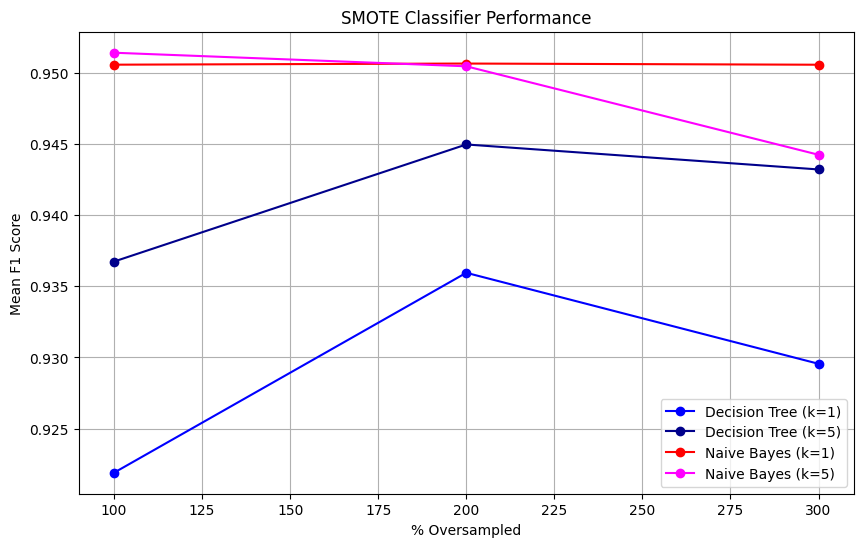

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

oversampling_percentages = [1.0, 2.0, 3.0]
k_values = [1, 5]
dec_tree_f1_scores_k1 = []
nb_f1_scores_k1 = []
dec_tree_f1_scores_k5 = []
nb_f1_scores_k5 = []

def smote_eval(X_train, y_train, X_test, y_test, k_neighbors, oversample_pct):

    X_train_resampled, y_train_resampled = smote(X_train, y_train, min_class=1, oversample_pct=oversample_pct, k=k_neighbors)

    #initialize and evaluate our DT classifier using SMOTE
    dec_tree = DecisionTreeClassifier(maximum_tree_depth=5)
    dec_tree.fit(X_train_resampled, y_train_resampled)    
    dec_tree_mean_f1, _ = test_performance(dec_tree, X_test, y_test, 10)

    #initialize and evaluate our NB classifier using SMOTE
    nb = NaiveBayesClassifier()
    nb.fit(X_train_resampled, y_train_resampled)
    nb_mean_f1, _ = test_performance(nb, X_test, y_test, 10)  # Use X_test, y_test here

    return dec_tree_mean_f1, nb_mean_f1

#for each of our oversampling percentages, we evaluate our classifiers using SMOTE at KNN of 1 and 5
for pct in oversampling_percentages:

    dec_tree_f1_k1, nb_f1_k1 = smote_eval(X_train, y_train, X_test, y_test, k_neighbors=1, oversample_pct=pct)
    dec_tree_f1_scores_k1.append(dec_tree_f1_k1)
    nb_f1_scores_k1.append(nb_f1_k1)
    
    dec_tree_f1_k5, nb_f1_k5 = smote_eval(X_train, y_train, X_test, y_test, k_neighbors=5, oversample_pct=pct)
    dec_tree_f1_scores_k5.append(dec_tree_f1_k5)
    nb_f1_scores_k5.append(nb_f1_k5)

plt.figure(figsize=(10, 6))
plt.plot([100, 200, 300], dec_tree_f1_scores_k1, label='Decision Tree (k=1)', marker='o', color='blue')
plt.plot([100, 200, 300], dec_tree_f1_scores_k5, label='Decision Tree (k=5)', marker='o', color='darkblue')
plt.plot([100, 200, 300], nb_f1_scores_k1, label='Naive Bayes (k=1)', marker='o', color='red')
plt.plot([100, 200, 300], nb_f1_scores_k5, label='Naive Bayes (k=5)', marker='o', color='magenta')
plt.xlabel('% Oversampled')
plt.ylabel('Mean F1 Score')
plt.title('SMOTE Classifier Performance')
plt.legend()
plt.grid(True)
plt.show()


We can see some interesting patterns revealed when looking at our classifiers' performance using the SMOTE technique. First, it appears that the Decision Tree classifier takes very well to oversampling with additional synthetic data.  As seen from chart, Naive Bayesclassifier performs better at all quantifications of kNeighbor and all sampling percentages than it does without any type of oversampling.  It performs best at 300% oversampling at k=5, indicating that more synthetic samples may increase the model's overall performance.
<br><br>

It does not look like oversampling with synthetic data has same positive impact on model performance for Decision Tree classifier as it does with Naive Bayes classifier.  We assumed that this is related to the feature indpendence assumption taken by Naive Bayes, which is less sensitive to class imbalance.

<h2> Phase 2: Unsupervised Techniques [50/100]</h2>

For all clustering results reported in this phase, when referring to “performance” you should run
 the clustering algorithm 10 times with different random initializations and report the average +/
standard deviation of the Silhouette coefficient. You may use the existing Silhouette implementation
 of Sklearn. When plotting the performance, you should always produce error-bars. Whenever your
 figure contains more than one line/graph (e.g., performance of two classifiers), you should always
 make sure those are easily distinguishable (use different colors and markers) and make sure you
 include a legend

<h2>1. k-means clustering [10pts]</h2>

What to implement:  You should implement Lloyd’s algorithm for k-means clustering and
 the k-means++ initialization algorithm as described in [5]. Your code should have an option
 to use either fully random or k-means++ initialization.

 What to plot: The performance of k-means for k ranging from 1 to 5 when using completely
 random initialization and when using k-means++

 [5]: https://dl.acm.org/doi/pdf/10.5555/1283383.1283494  

k-Means Class implements clustering algoirthm, including initialization, optimization and prediction for new data points

init_centers method generates initial clusters centers that have significant distance from each other.  Has two main initialiation options: 'random' and 'k-means++' 

assignClusters method assigns each point to the nearest cluster center from current cluster center through Euclidan distance calculation.  The output is a dictionary of clusters index and cluster assignment they have.  

hasConverged method ensures the cluster centers have stopped moving during iterations and that the results are stable.  Purpose of this method is to avoid computations that add no value.

reevaluateCenters method's purpose is to recalculate the cluster centers by taking average of points assigned to each cluster.  This refines cluster centers to give better representation to its surrounding datapoints

Fit method initializes the cluster centers, iteratively assigns points to clusters, recalculates cluster centers, and stops when convergence is reached or the maximum number of iterations is exceeded.  This is main method used to train model by finding best cluster assingments

Predict method predicts cluster assignments for a set of new points.  It calculates distances from each new point to all cluster centers & assigns each point to nearest cluster.  This method ensures model can classify unseen data

Sources:

 https://datasciencelab.wordpress.com/tag/lloyds-algorithm/ 
 
https://analyticsarora.com/k-means-for-beginners-how-to-build-from-scratch-in-python/

In [399]:
class Kmeans:
    def __init__(self, n_clusters=3, max_iter=100, tol=1e-4, init_method='random'):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.init_method = init_method
        self.centers = None
        self.clusters = None

    def init_centers(self, points):
    #Calculating/Understanding the number of rows & features within dataset
        numPoints, numFeatures = points.shape
    #Creating empty array to store K cluster centers
        centers = np.empty((self.n_clusters, numFeatures))
        if self.init_method == 'random':
        #Randomly selecting K rows as initial cluster centers
            for i in range(self.n_clusters):
                randomIndex = np.random.randint(numPoints)
                centers[i] = points[randomIndex]
        
        elif self.init_method == 'k-means++':
            #Having first center be random
            centers[0] = points[np.random.randint(numPoints)]
            #Calculating distance of each point to closest center already established
            for i in range (1, self.n_clusters):
                distances = np.min([np.linalg.norm(points - center, axis = 1)**2 for center in centers[:i]], axis = 0)
                #Next cluster center has probability proportional to its squared distance
                probabilities = distances / np.sum(distances)
                #Calculating cumulative probability for weighted random selection process
                cumulativeProbability = np.cumsum(probabilities)
            #Generating number between 0 and 1 to see which point chosen as next center
                r = np.random.rand()
                for j, p in enumerate(cumulativeProbability):
                    if r < p:
                        centers[i] = points[j]
                        break

        else:
            raise ValueError("Invalid method.  Choose either 'random' or 'k-means++'.  Check spelling and case sensitivity of input")

        return centers



    def assignClusters(self, points, centers):
        clusters = {}
        for x in points:
        #Finds closest cluster cetner to this point
            distances = [np.linalg.norm(x - center) for center in centers]
        #Obtaiing index of cluster center with smallest distance
            closestCenterIndex = np.argmin(distances)

        #New cluster
            if closestCenterIndex not in clusters:
                clusters[closestCenterIndex] = []
            clusters[closestCenterIndex].append(x)

        return clusters


    def hasConverged(self, newCenters, oldCenters, threshold=1e-4):
    # Calculating distance between old and new centers
        distances = [np.linalg.norm(new - old) for new, old in zip(newCenters, oldCenters)]
    
    # Check if all distances are below the threshold
    #True if all centers have moved less than threshold; false otherwise
        return all(dist < threshold for dist in distances)

    def reevaluateCenters(self, clusters):
    #Updated cluster centers stored here
        newCenters = []
    #Looping through clusters by their key
        for clusterIndex in sorted(clusters.keys()):
            clusterMean = np.mean(clusters[clusterIndex], axis = 0)
            newCenters.append(clusterMean)
        return newCenters
    
    #
    def fit(self, features):
        self.centers = self.init_centers(features)
        oldCenters = None

        for _ in range(self.max_iter):
            self.clusters = self.assignClusters(features, self.centers)
            newCenters = self.reevaluateCenters(self.clusters)
            if oldCenters is not None and self.hasConverged(newCenters, oldCenters):
                break
            oldCenters = self.centers
            self.centers = newCenters
        return self.clusters, self.centers

    def predict(self, points):
        clusterLabels = []
        for x in points:
            distances = [np.linalg.norm(x-center) for center in self.centers]
            clusterLabels.append(np.argmin(distances))
        return clusterLabels
    
    def fit_predict(self, features):
        self.fit(features)
        return self.predict(features)

The K-Means clustering algorithm is initialized, fitted onto dataset and makes new predictions.  Scaling is applied to dataset to enusre all features equally contribute to distance calculation in cluster algorithm.  The fitting of model on dataset idetnifies patterns by grouping the similar datapoints into clusters.  The model is then tested by using new data points and predicting cluster assignments.  The ouput will give insight into characteristics into each cluster and show which clusters the new datapoints belong ot


In [396]:
scaler = StandardScaler()
features_standard_scaled = scaler.fit_transform(features)
#Fitting the Kmeans model
kmeans = Kmeans(n_clusters=3, max_iter=100, tol=1e-4, init_method='k-means++')
clusters, centers = kmeans.fit(features_standard_scaled)
print("Cluster Centers:", centers)
#Making new points for a prediction
newPoints = features_standard_scaled[:2]
newPoints_scaled = scaler.transform(newPoints)
#Predicting cluster for new points
predictions = kmeans.predict(newPoints_scaled)
print("Predictions:", predictions)


Cluster Centers: [array([-0.44809508, -0.2418554 , -0.46954224, -0.44831604, -0.358676  ,
       -0.57356749, -0.59729151, -0.59473375, -0.34211158, -0.24188587,
       -0.41793414, -0.03526589, -0.42565126, -0.38816111, -0.10019852,
       -0.44614655, -0.38279548, -0.45090772, -0.09646964, -0.32238413,
       -0.48612661, -0.25310785, -0.50571337, -0.47269217, -0.37318328,
       -0.534009  , -0.56276526, -0.59707489, -0.31763162, -0.41144444]), array([-0.17232895,  0.17898672, -0.10074437, -0.22001438,  0.84922567,
        1.03543143,  0.78100563,  0.49942706,  0.75279302,  1.18398151,
       -0.08502958,  0.02340245, -0.01783062, -0.17235697,  0.43965152,
        1.07468661,  0.89050757,  0.75214074,  0.28645615,  1.0264176 ,
       -0.08822954,  0.31146754, -0.00701494, -0.15647731,  0.96915045,
        1.17977172,  1.0450547 ,  0.74299822,  0.80991644,  1.38461312]), array([ 1.61908207,  0.62661289,  1.6240009 ,  1.66315361,  0.39856469,
        0.93061442,  1.23933718,  1.486970

<h2>2. Density-based clustering with DBSCAN [15 pts]</h2>

What to implement:  You should implement the DBSCAN algorithm
What to plot: The performance of DBSCAN as a function of MinPts (taking values [5, 10,
 15, 20] and for (1) Eps = 0.1 and (2) Eps = 0.2 (two lines in total)

To implement the DBSCAN algorithm, we first created several helper functions to utilize throughout the process:

1. get_cluster_ss() - this function takes in the data and the cluster labels as parameters. It checks to see if there are more than one clusters in the set, and if so, returns the silhouette score of the clusters. If there is not more than one cluster created, then it returns a silhouette score of -1 since the clustering is invalid.

2. get_neighbors() - this function takes the data, a given point index and the eps value as parameters. We iterate over all points in the data and get the indices of the neighbors that fall within the euclidean distance cast by the passed in eps value.

3. expand_cluster() - this function takes the data, the labels for existing clusters, the neighbors of the cluster that was just created, the ID of the cluster just created, the eps and minPts values, and the set of visited points. We iterate over the neighbors of the core point , and evaluate their neighbors to determine whether or not they are core points as well. This allows us to iteratively grow, or expand, the given cluster that was created.

4. dbscan_impl() - this function takes the data, an eps value and minPts value as parameters. This is the function where we implement the DBSCAN algorithm. We start by initializing varables for the number of points, labels for the clusters, cluster id, and a set to track which points we've already evaluated. We iterate over each point, get the neighbors, and check to see if a cluster could be created. If not, we mark the point as noise. If so, we begin a new cluster, assign the next ID value, and call expand_cluster() to assign its neighbors the ID value of the associated cluster. The returned result is our list of cluster labels, the length of our total number of points, with the associated ID value of the cluster each point is assigned to (or -1 if the point was deemed to be noise).

5. evaluate_dbscan_performance() - this function takes the data, eps and minPts values, along with the number of runs we want for evaluating performance (in our case, 10). For each combination of eps and minPts values, we perform the DBSCAN algorithm and get the clustering labels of the data in return. With these labels, we call our helper function get_cluster_ss() and retrieve a silhouette score for the combination. We store the mean and standard deviation of the scores achieved over the 10 iterations for each combination, and return them all.

In [306]:
def get_cluster_ss(data, cluster_labels):
    unique_labels = set(cluster_labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    if n_clusters > 1:
        return silhouette_score(data, cluster_labels)
    else:
        return -1

def get_neighbors(data, point_idx, eps):
    nbrs = NearestNeighbors(radius=eps, metric='euclidean').fit(data)
    distances, indices = nbrs.radius_neighbors([data[point_idx]])
    return indices[0].tolist()

def expand_cluster(data, cluster_labels, neighbors, cluster_id, eps, min_points, visited_points):
    i = 0
    while i < len(neighbors):
        neighbor_idx = neighbors[i]

        if neighbor_idx not in visited_points:
            visited_points.add(neighbor_idx)
            new_neighbors = get_neighbors(data, neighbor_idx, eps)
            
            if len(new_neighbors) >= min_points:
                neighbors.extend([n for n in new_neighbors if n not in neighbors])

        if cluster_labels[neighbor_idx] == -1:
            cluster_labels[neighbor_idx] = cluster_id

        i += 1

def dbscan_impl(data, eps, min_points):
    points_count = data.shape[0]
    cluster_labels = [-1] * points_count
    cluster_id = 0
    visited_points = set()

    for point_idx in range(points_count):
        if point_idx in visited_points:
            continue

        visited_points.add(point_idx)
        neighbors = get_neighbors(data, point_idx, eps)

        if len(neighbors) >= min_points:
            cluster_id += 1
            cluster_labels[point_idx] = cluster_id
            expand_cluster(data, cluster_labels, neighbors, cluster_id, eps, min_points, visited_points)
    
    return cluster_labels


def evaluate_dbscan_performance(data, eps_values, min_points_values, num_runs):
    scores = {eps: [] for eps in eps_values}
    stdevs = {eps: [] for eps in eps_values}

    for eps in eps_values:
        for min_points in min_points_values:
            silhouette_scores = []
            
            for _ in range(num_runs):

                cluster_labels = dbscan_impl(data, eps, min_points)
                score = get_cluster_ss(data, cluster_labels)                
                silhouette_scores.append(score)
            
            print(f"SS for eps {eps} and minPts {min_points} : {np.mean(silhouette_scores)}")
            scores[eps].append(np.mean(silhouette_scores))
            stdevs[eps].append(np.std(silhouette_scores))
    
    return scores, stdevs

Now that we've created the DBSCAN algorithm from scratch along with our function evaluating the performance of each combination of eps and minPts, we can plot the results.

- First, we normalize the data using StandardScaler
- Then we establish our lists of all eps and minPts values we want to consider
- Then we call our evaluation function `evaluate_dbscan_performance()` to get the performance data back for each combination of eps and minPts
- Finally, we create a plot with bars for each combination, with a Y axis ranging from 1 to -1 representing the full range of any possible silhouette score, and display our results:

SS for eps 0.1 and minPts 5 : -0.3867666721343994
SS for eps 0.1 and minPts 10 : -1.0
SS for eps 0.1 and minPts 15 : -1.0
SS for eps 0.2 and minPts 5 : 0.15546467900276184
SS for eps 0.2 and minPts 10 : -0.30197709798812866
SS for eps 0.2 and minPts 15 : -1.0
SS for eps 0.3 and minPts 5 : 0.12639285624027252
SS for eps 0.3 and minPts 10 : 0.16246117651462555
SS for eps 0.3 and minPts 15 : -0.2738099694252014
SS for eps 0.4 and minPts 5 : 0.33638134598731995
SS for eps 0.4 and minPts 10 : 0.27403315901756287
SS for eps 0.4 and minPts 15 : 0.20531649887561798
SS for eps 0.5 and minPts 5 : 0.22224660217761993
SS for eps 0.5 and minPts 10 : 0.3613991141319275
SS for eps 0.5 and minPts 15 : 0.37179499864578247


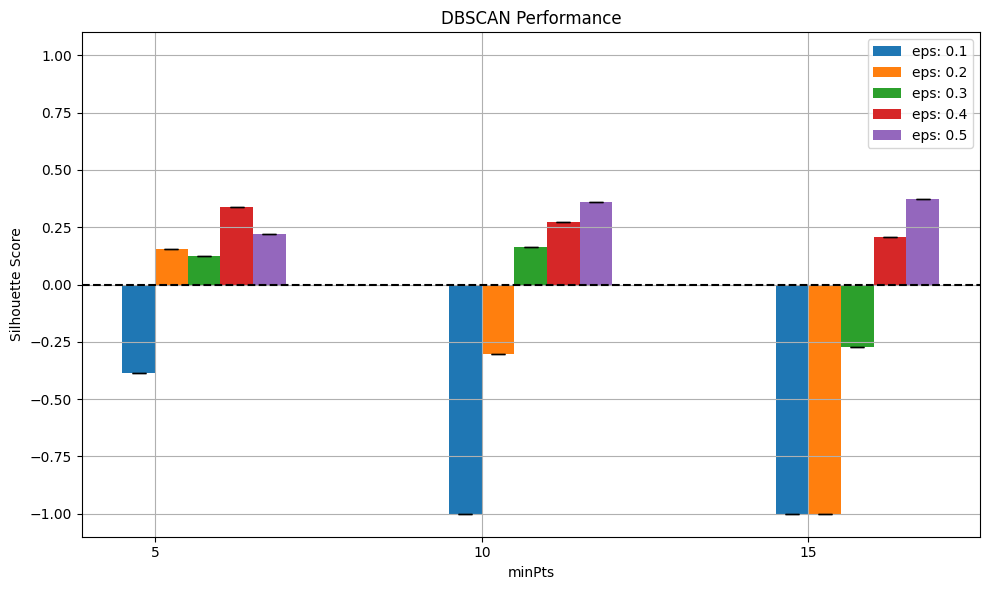

In [307]:
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

reducer = umap.UMAP(n_neighbors=10, min_dist=0.01, n_components=2)
umap_embedding = reducer.fit_transform(features_normalized)

min_pts_values = [5, 10, 15]
eps_values = [0.1, .2, .3, .4, .5]

performance, stdevs = evaluate_dbscan_performance(umap_embedding, eps_values, min_pts_values, 10)

plt.figure(figsize=(10, 6))
x = np.arange(len(min_pts_values))
bar_width = 0.1
for idx, eps in enumerate(eps_values):
    positions = x + (idx * bar_width)
    plt.bar(
        positions, 
        performance[eps], 
        bar_width, 
        yerr=stdevs[eps], 
        capsize=5, 
        label=f"eps: {eps}"
    )

plt.xticks(x + bar_width / 2, min_pts_values)
plt.title("DBSCAN Performance")
plt.xlabel("minPts")
plt.ylabel("Silhouette Score")
plt.axhline(0, color='black', linestyle='--')
plt.ylim(-1.1, 1.1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Throughout the evaluation process, we decided to add several higher eps values to the list to see if we could produce higher silhouette scores than the ones that were generated from eps of 0.1 and 0.2. As you can see from the above plot, our best score was generated by an eps of 0.5 and minPts of 15. This tells us that a larger eps value and moderately high number of minimum points produces the most meaningful clusters for this dataset. Although a silhouette score of 0.37 shows that the clustering of the data is only moderate, it still could provide meaningful insight on the data. <br><br>

<b>Challenges Encountered:</b> We struggled mightily to produce clusters of any sort of meaning using the DBSCAN algorithm. At first, we were only getting silhouette scores of -1 for all combinations of eps and minPts, even after normalizing the data. We tried numerous normalization approaches, including various types of Scalers, all which gave us the same results. We eventually decided to try creating a UMAP embedding of our normalized data, performing dimensionality reduction into two dimensions. When applying the DBSCAN algorithm on this embedding, we were finally able to generate some moderately meaningful clusters as you can see above.

<h2>3. Graph based clustering with Spectral Clustering [10 pts]</h2>

What to implement: You should implement the version of Spectral Clustering (titled “Un
normalized spectral clustering”) shown in Page 6 of [3]. You should implement the Gaussian
 similarity function as described in Section 2 [3].

What to plot: The performance of spectral clustering as a function of k ranging from 1 to 5,
 and for sigma equal to (1) 0.1, (2) 1, and (3) 10 (three lines in total)

 [3]: https://link.springer.com/article/10.1007/s11222-007-9033-z 

<h2>4. Anomaly detection with Isolation Forest [15 pts]</h2>

What to implement: You should implement the Isolation Forest anomaly detection algorithm as described in the original paper [4].

What to plot: The performance of k-means with k-means++ and k=2 on the data after removing the top [1%, 5%, 10%, 15%] of anomalies as determined by the Isolation Forest


[4]: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4781136 

For our implementation of the Isolation Forest anomaly detection algorithm, we created two classes. First, we created the <b>IsoTree</b> class - this class represents the individual trees created to isolate points and determine anomalies. Below is a detailed outline of the IsoTree class:

- init() - initializes the attributes of the IsoTree:
    - max_depth: controls the maximum depth of the tree, preventing it from recursively splitting forever. This value is passed in from the Forest itself when creating individual trees, to ensure they all share the same maximum depth.
    - feat_idx: the index of the feature being split
    - split_val: the threshold value of the split
    - left: left subtree created post-split
    - right: right subtree created post-split

- fit() - construct the tree, evaluate stopping criteria, split and recursively fit new subtrees until stopping criteria is met
- path_len() - keeps track of the length of the path (or number or splits) needed to isolate the point - if a leaf node is reached, calls leaf_exp_path_len() to get the approx. path length if splitting indefinitely
- leaf_exp_path_len() - as mentioned above, implements the formula approximating the estimated path length for the point if splitting were allowed to continue

We also created a helper function get_avg_path_len() - this function is called by both the IsoTree and IsoForest helper methods to get the approximate path length for a sample of points of n size.

In [384]:
class IsoTree:
    def __init__(self, max_depth):
        self.max_depth = max_depth
        self.feat_idx = None
        self.split_val = None
        self.left = None
        self.right = None
        self.size = 0

    def fit(self, X, current_height=0):
        #stop if we've reached the assigned max depth or isolated the datapoint
        self.size = X.shape[0]
        if current_height >= self.max_depth or self.size <= 1:
            return self
        
        #randomly select new feature and threshold to use for the next split
        self.feat_idx = np.random.randint(X.shape[1])
        min_val, max_val = X[:, self.feat_idx].min(), X[:, self.feat_idx].max()
        self.split_val = np.random.uniform(min_val, max_val)

        #perform new split based on threshold 
        left_split = X[:, self.feat_idx] < self.split_val
        right_split = X[:, self.feat_idx] >= self.split_val

        #recall fit to create new subtrees, continue trying to isolate point
        self.left = IsoTree(self.max_depth).fit(X[left_split], current_height + 1)
        self.right = IsoTree(self.max_depth).fit(X[right_split], current_height + 1)

        return self

    def path_len(self, X):
        #determine whether we've reached a leaf node
        if self.left is None or self.right is None:
            #if so, get approx leaf path length
            return np.full(X.shape[0], self.leaf_exp_path_len())
        else:
            #split into left and right subtrees
            left_split = X[:, self.feat_idx] < self.split_val
            right_split = X[:, self.feat_idx] >= self.split_val

            path = np.zeros(X.shape[0])

            #recall path_len on both left and right subtrees to get path lengths
            if self.left:
                path[left_split] = self.left.path_len(X[left_split])
            if self.right:
                path[right_split] = self.right.path_len(X[right_split])

            return path + 1

    def leaf_exp_path_len(self):
        if self.size == 1:
            #path length is 1 if we've reached a single point in the leaf node
            return 1
        elif self.size > 1:
            #implement formula estimating number of splits needed to isolate points if num points > 1
            return get_avg_path_len(self.size)
        else:
            #return zero in case somehow we have zero points in the node (something went wrong with the split probably)
            return 0
        

def get_avg_path_len(n_points):
    return 2 * (np.log(n_points - 1) + 0.577) - 2 * (n_points - 1) / n_points


The next class we created was the <b>IsoForest</b> class - this class creates multiple IsoTrees to detect anomalies in the dataset. Below is a breakdown of the  methods and functionality:

- init() - initializes the attributes of the forest:
    - num_trees: the number of IsoTrees to create in the forest
    - sample: the number of data points we want to sample for training each IsoTree
    - trees: a list holding the IsoTrees we create
    - max_depth: the maximum depth of each IsoTree in the forest. We set this to log2(n) as this is the expected depth of a binary tree.

- fit() - construct our forest by training the specified number of IsoTrees
- get_anomaly_score() - get the anomaly score for each point

In [407]:
class IsoForest:
    def __init__(self, num_trees=100, sample=256):
        self.num_trees = num_trees
        self.sample = sample
        self.trees = []
        self.max_depth = int(np.ceil(np.log2(self.sample)))

    def fit(self, data):
        self.trees = []
        for _ in range(self.num_trees):
            #get subsample of our data based on the specified size of the sample, then create and train an IsoTree based off this subsample
            subsample = data[np.random.choice(data.shape[0], self.sample, replace=False)]
            tree = IsoTree(self.max_depth)
            tree.fit(subsample)
            self.trees.append(tree)
        return self

    def get_anomaly_score(self, data):
        #get the path lengths for our data, and calculate how they compare to the avg path length for a dataset of size n
        path_lengths = np.zeros(data.shape[0])
        for tree in self.trees:
            path_lengths += tree.path_len(data)
        path_lengths /= self.num_trees
        n = self.sample
        scores = 2 ** -(path_lengths / get_avg_path_len(n))
        return scores


After creating the IsoTree and IsoForest classes, we can begin our evaluation of the anomalies in the dataset:

1. Define helper function remove_pct_anomalies() - this function takes in the data, our scores, and the % of top anomalies we want to remove. For this assignment, we are removing 1%, 5%, 10% and 15%. 
2. We create an IsoForest instance - I used num_trees of 500 and sample of 500, since our dataset is small I wanted to limit the randomness with a relatively high sample for each tree.
3. Get the silhouette scores of the data in our forest
4. Create helper function evaluate_kmeans():
    - this function performs a run for each iteration of num_runs, and calls our custom Kmeans implementation to get the scores for our data
    - it returns the mean and standard deviations of the scores
5. We then iterate over each test anomaly percentage and remove the top anomalies from the data. Then, we evaluate kmeans to see how the mean silhouette scores compare to each other when different %s of anomalies have been removed.

In [413]:
def remove_pct_anomalies(features, scores, top_percent):
    threshold = np.percentile(scores, 100 * (1 - top_percent))
    #return the subset of the feature data without the top % of anomalies
    filtered = features[scores < threshold]
    return filtered

forest = IsoForest(num_trees=500, sample=500)
forest.fit(features)
scores = forest.get_anomaly_score(features)

def evaluate_kmeans(features, num_runs=10):
    scores = []
    for _ in range(num_runs):
        #call our custom kmeans impl to retrieve predicted clustering values, calculate silhouette scores and return the mean/stdevs
        kmeans = Kmeans(n_clusters=2, init_method='k-means++')
        labels = kmeans.fit_predict(features)
        score = silhouette_score(features, labels)
        scores.append(score)
    
    mean_sil = np.mean(scores)
    stdev_sil = np.std(scores)
    return mean_sil, stdev_sil

anomaly_percentages = [0.01, 0.05, 0.10, 0.15]
mean_scores = []
std_scores = []
for percent in anomaly_percentages:
    filtered_features = remove_pct_anomalies(features, scores, top_percent=percent)
    mean_sil, stdev_sil = evaluate_kmeans(filtered_features)
    mean_scores.append(mean_sil)
    std_scores.append(stdev_sil)

    print(f"Anomaly Removal {int(percent*100)}% --- Mean Silhouette: {mean_sil:.4f} --- StDev: {stdev_sil:.4f}")


Anomaly Removal 1% --- Mean Silhouette: 0.6980 --- StDev: 0.0001
Anomaly Removal 5% --- Mean Silhouette: 0.7006 --- StDev: 0.0000
Anomaly Removal 10% --- Mean Silhouette: 0.7016 --- StDev: 0.0000
Anomaly Removal 15% --- Mean Silhouette: 0.7012 --- StDev: 0.0000


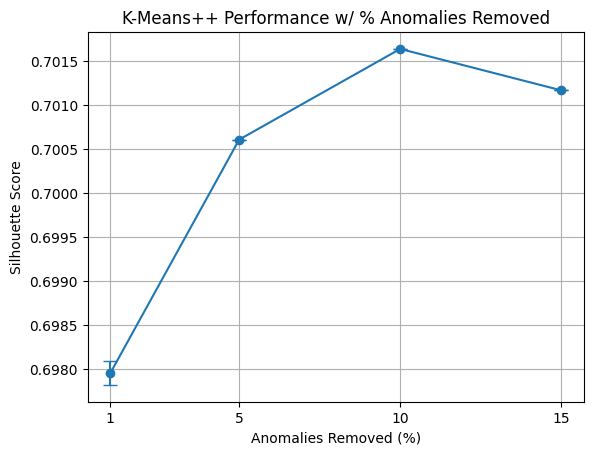

In [422]:
plt.errorbar(
    [1, 5, 10, 15],
    mean_scores,
    yerr=std_scores,
    fmt='o-',
    capsize=5,
)

plt.title("K-Means++ Performance w/ % Anomalies Removed")
plt.xlabel("Anomalies Removed (%)")
plt.ylabel("Silhouette Score")
plt.xticks([1, 5, 10, 15])
plt.grid(True)
plt.show()


As we can see from the plot, the mean Silhouette Score tended to increase as the % anomalies removed from the data was increased. It appears that the score began to level out and produce diminishing returns as more than 10% of anomalies were removed, suggesting that the remaining anomalies don't have a major impact on the cluster quality. Overall, the difference in silhouette scores across varying percentages of anomalies being removed was not extremely different, ranging from a low of 0.6980 at 1% removal and a high of 0.7016 at 10% removal, suggesting our dataset does not have significant anomalies impacting that impact the clustering.